# HEOM solver - Two level system
## An exact solution to a system-bath evolution using the hierarchical equations of motion and the Drude-Lorentz model for spectral density

Authors: Alexander Pitchford (alex.pitchford@gmail.com),
         Neill Lambert (nwlambert@gmail.com)

## Introduction
### Hierarchical equations of motion

The HEOM (hierarchical equations of motion) method can compute open system dynamics without using any Markovian or rotating wave approximation (RWA) for systems where the bath correlations can be approximated to a sum of complex eponentials. The bath is described in an abstract way, via a formal expansion of the full system-bath equation of motion, which results in a set of coupled "density matrices" for the system. A overview of the method is given in [1].

The HEOM solver will compute the dynamics of a quantum system coupled to a bath with a complete Hamiltonian given by

\begin{equation*}
H = H_s + Q\sum_{j}g_j(a_j^{\dagger}+a_j) + \sum_{j}\omega_j a_j^{\dagger}a_j
\end{equation*}

The dynamics of the quantum system of interest, if independent of the environment, would be described the system Hamiltonian $H_s$. The $a_j^{\dagger}$ and $a_j$ are the creation and annihilation operators of the bosonic modes of frequency $\omega_j$ of the bath that models the environment. The system operator Q couples with the bath with a strength $g_j$ for each mode.

### Drude-Lorentz spectral density
The spectral density determines the strength of the interact for specific modes. The Drude-Lorentz (DL) model for the spectral density is given by

$$J(\omega)=\omega \frac{2\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ is an overall scale factor for the coupling strength, and $\gamma$ is a cut-off frequency

The correlation function can be calculated via Fourier transform and gives an infinite exponential series of the form

\begin{equation*}
L(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

as this is in the form of a sum of exponentials it allows us to use the HEOM. Some cut-off for $k$ will be required  in order for it to be computable; in practice this is typically quite small ($<5$). The series term frequencies and coefficients (known as Matsubara terms, frequencies and coefficients in the DL model) as given by

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta \hbar}  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) / \hbar               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \hbar^2 \}    & k \geq 1\\
           \end{cases}
\end{equation*}

### Two-level system example
The example system in this notebook is taken from [2], which also gives an overview of the HEOM method in its appendix D. Here we look to compute the dynamics of a system where

\begin{equation*}
H_s = \frac{\epsilon}{2}\sigma_z + \frac{\Delta}{2}\sigma_x
\end{equation*}

and the coupling operator $Q=\sigma_z$. The energy of the two level system is given by $\epsilon$, the strength of the tunnelling effect by $\Delta$. This model is of much interest in the study of the potential quantum effects at work in photosynthesis, as discussed in some of the papers cited in [2]

### References
    1. link.aps.org/doi/10.1103/PhysRevLett.104.250401 
    2. link.aps.org/doi/10.1103/PhysRevA.90.032114

In [1]:
%pylab inline
import numpy as np
from qutip import sigmax, sigmay, sigmaz, basis, expect
from qutip.nonmarkov.heom import HSolverDL


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Populating the interactive namespace from numpy and matplotlib


In [10]:
# Defining the system Hamiltonian
eps = 0.5     # Energy of the 2-level system.
Del = 1.0    # Tunnelling term
Hsys = 0.5*eps*sigmaz() + 0.5*Del* sigmax()

In [27]:
# Bath description parameters (for HEOM)
temperature = 1.0/0.95 # in units where Boltzmann factor is 1
Nk = 2 # number of exponentials in approximation of the the spectral density
Ncut = 60 # cut off parameter for the bath

In [28]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator
gam = 2 # cut off frequency
lam = 0.01 # coupling strenght

In [29]:
# Configure the solver
import time
start = time.time()

hsolver = HSolverDL(Hsys, Q, lam, temperature, Ncut, Nk, gam, stats=True)
end = time.time()
print(end - start)



3.338186502456665


In [30]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)
tlist = np.linspace(0, 600, 6000)
# run the solver
result = hsolver.run(rho0, tlist)
hsolver.stats.report()

Hierarchy Solver Stats

config
------
### Timings:
 - 0:00:03.306170 (99.09% section, 0.31% total)	hierarchy contruct
 - 0:00:00.002151 (0.06% section, 0.00% total)	Liouvillian contruct
 - 0:00:03.336677	config total time
### Counts:
 - 1891	Num hierarchy elements
 - 7320	Num he interactions
### Messages:
 - options:	renormalisation;boundary cutoff approx

run
---
### Timings:
 - 0:00:00.000429 (0.00% section, 0.00% total)	initialize
 - 0:17:50.317983 (100.00% section, 99.69% total)	integrate
 - 0:17:50.318435	run total time
### Counts:
### Messages:

Summary
-------
0:17:53.655113	 solver total time


In [31]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp = expect(result.states, P11p)
P12exp = expect(result.states, P12p)

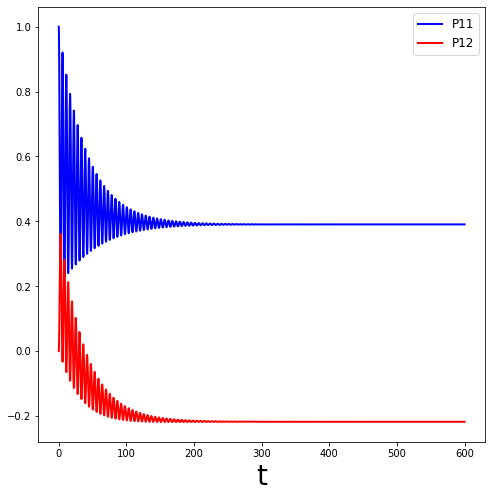

In [26]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

### Software versions

In [9]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
